# Creating small dataset out of 1 image

Since for some reason method **show** doesn't work with the images i decided to save them in working directory and show the **screenshots**

## Uplading the image

upload the image to variable and check the current size. Also just make sure that images mode is **RGB**:

In [1]:
from PIL import Image
import subprocess

img_path = '../pythonProject/Cat.jpg'

img = Image.open(img_path)

width, height = img.size
print(width, height)

img.show()
# subprocess.run(["mspaint", img_path])

736 736


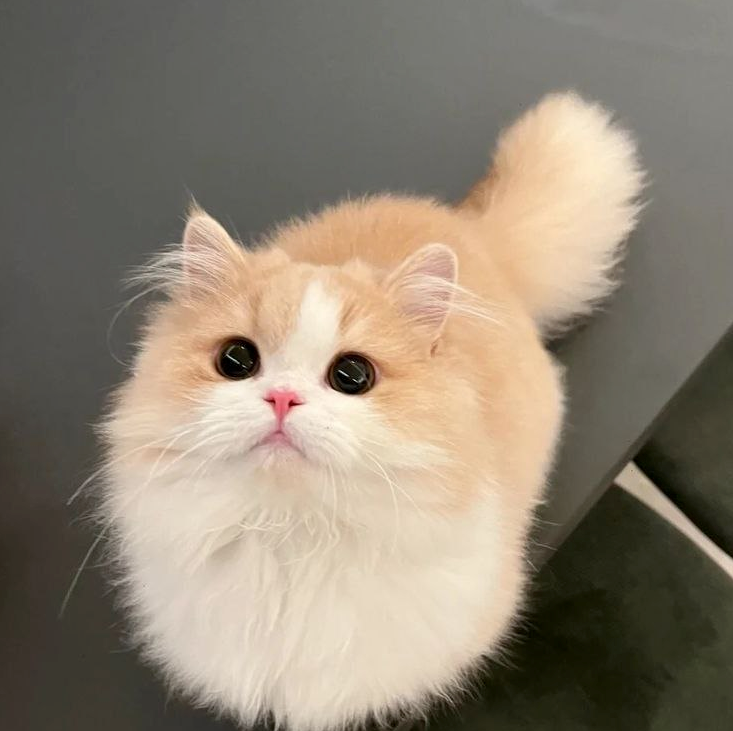

In [2]:
img.mode

'RGB'

We need smaller images to optimize the algorythm synce every single pixel counts as a variable. so next step is **resizing**

In [76]:
new_image = img.resize((256, 256))

width, height = new_image.size
print(width, height)

# new_image.show()

256 256


In [77]:
new_image.save('../pythonProject/Cat.jpg')

## Making mask of the cat

Since we have to show to programm where he cat is we need to **make a mask** of the cat

In [13]:
red, green, blue = img.split()

red.save('red.jpg')
blue.save('blue.jpg')
green.save('green.jpg')

The red one is the most contrast since the cat is so bright

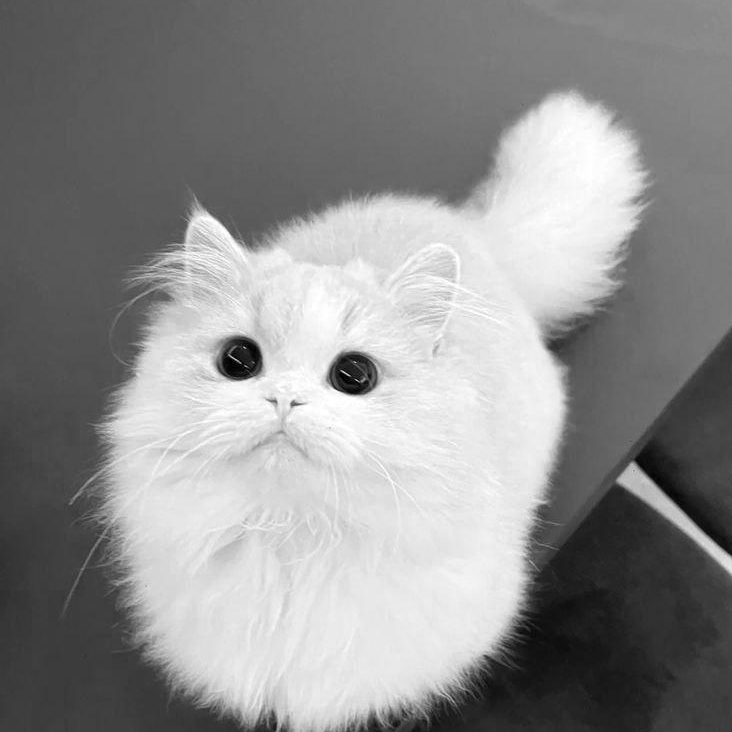

In [56]:
threshold_1 = 255
threshold_2 = 200
img_threshold = red.point(lambda x: 255 if x < threshold_1 and x > threshold_2 else 0)
img_threshold = img_threshold.convert("1")

img_threshold.save('mask.jpg')

Now we need to correct the image because the white area must **wrap the whole cat**

In [57]:
def erode(cycles, image):
    for _ in range(cycles):
         image = image.filter(ImageFilter.MinFilter(3))
    return image


def dilate(cycles, image):
    for _ in range(cycles):
         image = image.filter(ImageFilter.MaxFilter(3))
    return image



In [58]:
step_1 = erode(5, img_threshold)

step_1.save('mask.jpg')

In [59]:
step_2 = dilate(26, step_1)

step_2.save('mask.jpg')

In [60]:
mask = erode (5, step_2)

mask.save('mask_.jpg')

In [67]:
mask = mask.convert("L")
mask = mask.filter(ImageFilter.BoxBlur(20))

mask.save('mask.jpg')

width, height = mask.size
print(width, height)

736 736


In [68]:
mask = mask.resize((256, 256))

In [69]:
blank = new_image.point(lambda _: 0)
cat_segmented = Image.composite(new_image, blank, mask)
cat_segmented.save('cutcat.jpg')

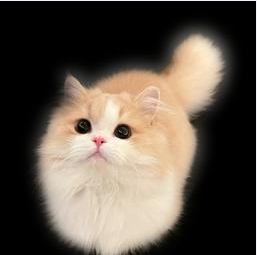

Nice

In [71]:
pip install pillow opencv-python

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 495.5 kB/s eta 0:01:19
   ---------------------------------------- 0.0/38.8 MB 495.5 kB/s eta 0:01:19
   ---------------------------------------- 0.0/38.8 MB 495.5 kB/s eta 0:01:19
   ---------------------------------------- 0.1/38.8 MB 273.8 kB/s eta 0:02:22
   ---------------------------------------- 0.1/38.8 MB 350.1 kB/s eta 0:01:51
   ---------------------------------------- 0.1/38.8 MB 473.7 kB/s eta 0:01:22
   ---------------------------------------- 0.1/38.8 MB 473.7 kB/s eta 0:01:22
   ---------------------------------------- 0.2/38.8 MB 409.6 kB/s eta 0:01:35
   ---------------------------------------- 0.2/38.8 MB 492.1 kB/s eta 0:01:19
   ---------------------------------------- 0.2/38.8 MB 519.9 kB/s eta 0:01:15
   ---------------------------------------- 0.3/38.8 MB 512.0 kB/s eta


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [79]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter

def augment_image(img, mask, idx):

    transformations = []

    # Вращения
    rotations = [90, 180, 270]
    for angle in rotations:
        rotated_img = img.rotate(angle)
        rotated_mask = mask.rotate(angle)
        transformations.append((rotated_img, rotated_mask))

    # Размытие
    blurred_img = img.filter(ImageFilter.GaussianBlur(radius=5))
    transformations.append((blurred_img, mask))

    # Увеличение резкости
    sharp_img = ImageEnhance.Sharpness(img).enhance(2.0)
    transformations.append((sharp_img, mask))

    # Повышение контраста
    contrast_img = ImageEnhance.Contrast(img).enhance(1.5)
    transformations.append((contrast_img, mask))

    # Обрезка
    width, height = img.size
    cropped_img = img.crop((width * 0.1, height * 0.1, width * 0.9, height * 0.9))
    cropped_mask = mask.crop((width * 0.1, height * 0.1, width * 0.9, height * 0.9))
    transformations.append((cropped_img, cropped_mask))

    # Вращение с зеркалированием
    rotated_with_color_img = img.rotate(45).transpose(Image.FLIP_LEFT_RIGHT)
    rotated_with_color_mask = mask.rotate(45).transpose(Image.FLIP_LEFT_RIGHT)
    transformations.append((rotated_with_color_img, rotated_with_color_mask))

    # Инверсия
    inverted_img = Image.fromarray(255 - np.array(img))
    inverted_mask = Image.fromarray(255 - np.array(mask))
    transformations.append((inverted_img, inverted_mask))

    return transformations[:idx]

def create_dataset(source_path_img, source_path_mask, target_folder, num_images):

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    img = Image.open(source_path_img)
    mask = Image.open(source_path_mask)
    count = 0
    
    while count < num_images:
        augmentations = augment_image(img, mask, min(num_images - count, 7))  # Ограничение на количество аугментаций за раз
        for augmented_img, augmented_mask in augmentations:
            if count >= num_images:
                break
            output_img_path = os.path.join(target_folder, f"cat_{count:03d}.png")
            output_mask_path = os.path.join(target_folder, f"mask_{count:03d}.png")
            augmented_img.save(output_img_path)
            augmented_mask.save(output_mask_path)
            count += 1

## Creating Dataset

In [81]:
# Использование
source_image = "Cat.jpg"
source_mask = "cutcat.jpg"
output_folder = "Dataset"
number_of_images = 100 

create_dataset(source_image, source_mask, output_folder, number_of_images)